<a href="https://colab.research.google.com/github/reginafeles/sentiment_cnn/blob/master/model/task3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets tensorflow sklearn

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
!pip install -U datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 11.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pl

In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 5.3 MB/s eta 0:00:00


In [ ]:
import re
import numpy as np
import pandas as pd
from collections import Counter
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

nltk.download("punkt_tab")
nltk.download("wordnet")
nltk.download("stopwords")

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D,
    Flatten, Dense, Dropout, BatchNormalization
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

import keras_tuner as kt


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#Датасет
https://www.kaggle.com/datasets/abdelmalekeladjelet/sentiment-analysis-dataset, комментарии с разных онлайн-платформ (думаю, что источники соцсети только)
#Минусы датасета:
- похоже, эти данные собирал гражданин Индии, иначе я не могу объяснить причину появления большого колва индийских слов в датасете, отсюда не очень понятно, о чем конкретно датасет (но много текстов о политике)
#Плюсы:
- живые данные, так как в текстах есть много несуществующих слов или слов с ошибками, это интересно

In [ ]:
df = pd.read_csv("sentiment_data.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241145 entries, 0 to 241144
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  241145 non-null  int64 
 1   Comment     240928 non-null  object
 2   Sentiment   241145 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 5.5+ MB


In [ ]:
df.head(5)

In [ ]:
df = df.dropna(subset=["Sentiment"])
df["Sentiment"] = df["Sentiment"].astype(int)

#EDA

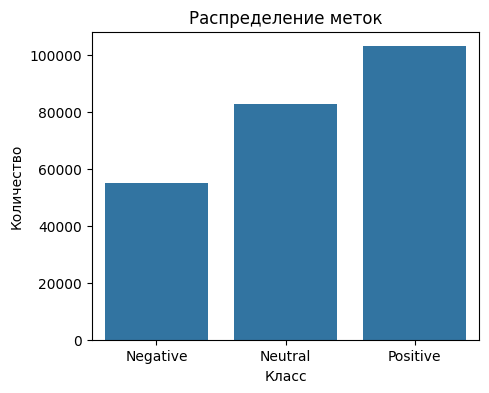

In [ ]:
label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}

def plot_label_dist(df):
    counts = df["Sentiment"].value_counts().sort_index()
    plt.figure(figsize=(5,4))
    sns.barplot(x=[label_map[i] for i in counts.index], y=counts.values)
    plt.title(f"Распределение меток")
    plt.ylabel("Количество"); plt.xlabel("Класс")
    plt.show()

plot_label_dist(df)

Несбалансированный датасет, поэтому при обучении сбалансируем классы через веса

In [ ]:
df_train, df_temp = train_test_split(df, test_size=0.2, stratify=df.Sentiment, random_state=42)
df_val, df_test = train_test_split(df_temp, test_size=0.5, stratify=df_temp.Sentiment, random_state=42)

print(df_train.shape, df_val.shape, df_test.shape)

(192916, 3) (24114, 3) (24115, 3)


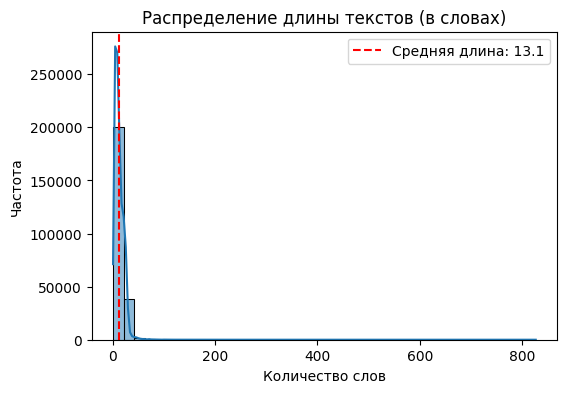

Средняя длина текста: 13.05 слов


In [ ]:
def text_length(df):
    lengths = df["Comment"].apply(lambda x: len(word_tokenize(str(x))))
    avg_length = np.mean(lengths)

    plt.figure(figsize=(6, 4))
    sns.histplot(lengths, bins=40, kde=True)
    plt.axvline(avg_length, color='red', linestyle='--', label=f'Средняя длина: {avg_length:.1f}')
    plt.title("Распределение длины текстов")
    plt.xlabel("Количество слов")
    plt.ylabel("Частота")
    plt.legend()
    plt.show()

    print(f"Средняя длина текста: {avg_length:.2f}")

text_length(df)

Датасет уже был почищен, но я все равно провела предобработку, чтобы быть уверенной, что данные ок

Средняя длина 13.1 - очень мало, поэтому я решила увеличить этот показатель до 50

#Обучение

In [ ]:
def clean_text(x):
    x = str(x).lower()
    x = re.sub(r"http\S+|[^a-z\s]", " ", x)
    x = re.sub(r"\s+", " ", x).strip()
    return x

for d in [df_train, df_val, df_test]:
    d["text_clean"] = d["Comment"].apply(clean_text)

tokenizer = Tokenizer(num_words=20000, oov_token="<OOV>")
tokenizer.fit_on_texts(df_train["text_clean"])

def prep(df, maxlen=50):
    seq = tokenizer.texts_to_sequences(df["text_clean"])
    seq = pad_sequences(seq, maxlen=maxlen, padding="post", truncating="post")
    labels = pd.get_dummies(df["Sentiment"]).values
    return seq, labels

X_train, y_train = prep(df_train)
X_val, y_val = prep(df_val)
X_test, y_test = prep(df_test)

In [ ]:
model = Sequential([
    Embedding(input_dim=20000, output_dim=128, input_length=50),
    Conv1D(128, 5, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(2),
    Conv1D(64, 5, activation='relu', padding='same'),
    BatchNormalization(),
    GlobalMaxPooling1D(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.4),
    Dense(3, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
optimizer = Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_2          │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Добавила early stopping, чтобы не ждать все эпохи, когда val_accuracy падает в течение двух эпох

In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)
class_weights = compute_class_weight('balanced', classes=np.unique(np.argmax(y_train, axis=1)),
                                     y=np.argmax(y_train, axis=1))
class_weights = dict(enumerate(class_weights))

history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=256,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    class_weight=class_weights
)

Epoch 1/20
754/754 ━━━━━━━━━━━━━━━━━━━━ 195s 254ms/step - accuracy: 0.4004 - loss: 1.6286 - val_accuracy: 0.5397 - val_loss: 1.0571
Epoch 2/20
754/754 ━━━━━━━━━━━━━━━━━━━━ 196s 246ms/step - accuracy: 0.6274 - loss: 0.9238 - val_accuracy: 0.7434 - val_loss: 0.7219
Epoch 3/20
754/754 ━━━━━━━━━━━━━━━━━━━━ 207s 252ms/step - accuracy: 0.8046 - loss: 0.6063 - val_accuracy: 0.7837 - val_loss: 0.6368
Epoch 4/20
754/754 ━━━━━━━━━━━━━━━━━━━━ 186s 246ms/step - accuracy: 0.8680 - loss: 0.4431 - val_accuracy: 0.7803 - val_loss: 0.6617
Epoch 5/20
754/754 ━━━━━━━━━━━━━━━━━━━━ 187s 248ms/step - accuracy: 0.9117 - loss: 0.3187 - val_accuracy: 0.7848 - val_loss: 0.7149


In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 50, 128)        │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 50, 128)        │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 50, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 25, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 25, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 25, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_2          │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,076,875 (30.81 MB)

 Trainable params: 2,692,163 (10.27 MB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 5,384,328 (20.54 MB)

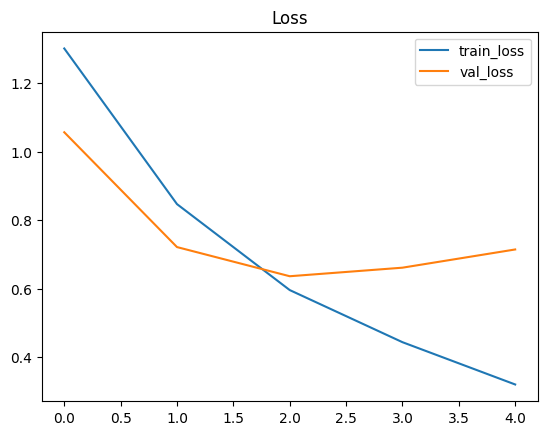

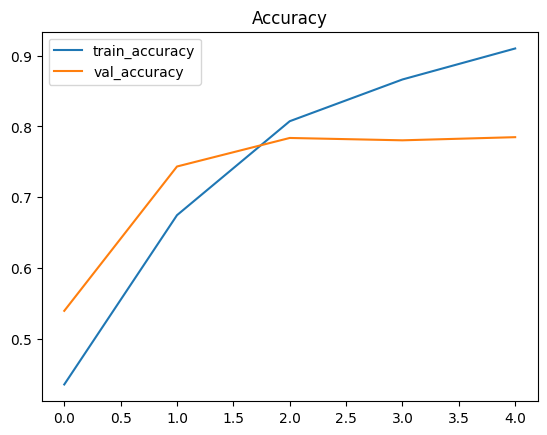

In [ ]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.title("Accuracy")
plt.show()

754/754 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step
              precision    recall  f1-score   support

    negative       0.73      0.72      0.73      5512
     neutral       0.77      0.80      0.78      8297
    positive       0.83      0.82      0.82     10306

    accuracy                           0.79     24115
   macro avg       0.78      0.78      0.78     24115
weighted avg       0.79      0.79      0.79     24115

[[3976  805  731]
 [ 693 6599 1005]
 [ 757 1145 8404]]


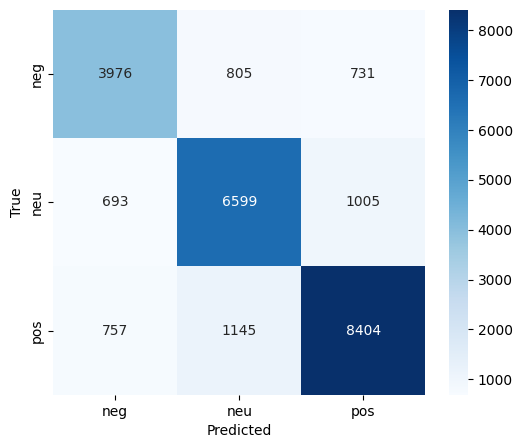

In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print(classification_report(y_true, y_pred_classes, target_names=["negative","neutral","positive"]))
cm = confusion_matrix(y_true, y_pred_classes)
print(cm)

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["neg","neu","pos"], yticklabels=["neg","neu","pos"])
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()

Результат неплохой, но подбор гиперпараметров занимает слишком много сил, поэтому я нашла фреймворк keras_tuner, который позволяет найти наиболее оптимальные гиперпараметры. Для инициализации могут быть использованы Bayesian Optimization, Hyperband или Random Search, я остановилась именно на Random Search

In [ ]:
lengths = df['Comment'].apply(lambda x: len(str(x).split()))
MAX_LEN = int(np.percentile(lengths, 95))
MAX_LEN

27

In [ ]:
def build_model(hp):
    model = Sequential()
    model.add(Embedding(
        input_dim=20000,
        output_dim=hp.Choice('embedding_dim', [64, 128, 256]),
        input_length=MAX_LEN
    ))
    model.add(Conv1D(
        filters=hp.Choice('filters_1', [64, 128, 256]),
        kernel_size=hp.Choice('kernel_size_1', [3, 5, 7]),
        activation='relu',
        padding='same'
    ))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(
        filters=hp.Choice('filters_2', [32, 64, 128]),
        kernel_size=hp.Choice('kernel_size_2', [3, 5]),
        activation='relu',
        padding='same'
    ))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(
        units=hp.Choice('dense_units', [32, 64, 128]),
        activation='relu'
    ))
    model.add(Dropout(hp.Float('dropout_rate', 0.3, 0.6, step=0.1)))
    model.add(Dense(3, activation='softmax'))

    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [ ]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1)

tuner.search(X_train, y_train,
             epochs=5,
             batch_size=128,
             validation_data=(X_val, y_val),
             callbacks=[EarlyStopping(patience=2)])


Trial 10 Complete [00h 06m 41s]
val_accuracy: 0.8101543188095093

Best val_accuracy So Far: 0.8334226012229919
Total elapsed time: 02h 23m 36s


In [ ]:
best = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Лучшие параметры:")
print(f"- embedding_dim: {best.get('embedding_dim')}")
print(f"- filters_1: {best.get('filters_1')}, kernel_size_1: {best.get('kernel_size_1')}")
print(f"- filters_2: {best.get('filters_2')}, kernel_size_2: {best.get('kernel_size_2')}")
print(f"- dense_units: {best.get('dense_units')}")
print(f"- dropout_rate: {best.get('dropout_rate')}")
print(f"- learning_rate: {best.get('learning_rate')}")


Лучшие параметры:
- embedding_dim: 64
- filters_1: 128, kernel_size_1: 7
- filters_2: 32, kernel_size_2: 3
- dense_units: 128
- dropout_rate: 0.5
- learning_rate: 0.001


In [ ]:
model = Sequential([
    Embedding(input_dim=20000, output_dim=64, input_length=50),
    Conv1D(128, 7, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(2),
    Conv1D(32, 3, activation='relu', padding='same'),
    BatchNormalization(),
    GlobalMaxPooling1D(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
optimizer = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)
class_weights = compute_class_weight('balanced', classes=np.unique(np.argmax(y_train, axis=1)),
                                     y=np.argmax(y_train, axis=1))
class_weights = dict(enumerate(class_weights))

history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=256,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    class_weight=class_weights
)

Epoch 1/20
754/754 ━━━━━━━━━━━━━━━━━━━━ 146s 186ms/step - accuracy: 0.6034 - loss: 0.9613 - val_accuracy: 0.8190 - val_loss: 0.5166
Epoch 2/20
754/754 ━━━━━━━━━━━━━━━━━━━━ 126s 166ms/step - accuracy: 0.8477 - loss: 0.4519 - val_accuracy: 0.8284 - val_loss: 0.5015
Epoch 3/20
754/754 ━━━━━━━━━━━━━━━━━━━━ 141s 165ms/step - accuracy: 0.8936 - loss: 0.3192 - val_accuracy: 0.8408 - val_loss: 0.4873
Epoch 4/20
754/754 ━━━━━━━━━━━━━━━━━━━━ 142s 165ms/step - accuracy: 0.9303 - loss: 0.2120 - val_accuracy: 0.8437 - val_loss: 0.5479
Epoch 5/20
754/754 ━━━━━━━━━━━━━━━━━━━━ 143s 166ms/step - accuracy: 0.9558 - loss: 0.1413 - val_accuracy: 0.8379 - val_loss: 0.6212


In [ ]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 50, 64)         │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 50, 128)        │        57,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 50, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 25, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 25, 32)         │        12,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 25, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_3          │ (None, 32)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,064,491 (15.50 MB)

 Trainable params: 1,354,723 (5.17 MB)

 Non-trainable params: 320 (1.25 KB)

 Optimizer params: 2,709,448 (10.34 MB)

754/754 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step
              precision    recall  f1-score   support

    negative       0.79      0.79      0.79      5512
     neutral       0.84      0.86      0.85      8297
    positive       0.88      0.86      0.87     10306

    accuracy                           0.84     24115
   macro avg       0.84      0.84      0.84     24115
weighted avg       0.84      0.84      0.84     24115

[[4377  549  586]
 [ 567 7142  588]
 [ 615  859 8832]]


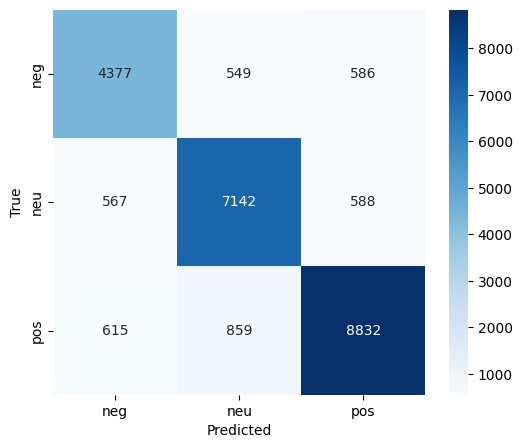

In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print(classification_report(y_true, y_pred_classes, target_names=["negative","neutral","positive"]))
cm = confusion_matrix(y_true, y_pred_classes)
print(cm)

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["neg","neu","pos"], yticklabels=["neg","neu","pos"])
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()

In [ ]:
model.save("sentiment_model.keras")
# Для сохранения токенизатора:
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

In [ ]:
from google.colab import files
files.download('sentiment_model.keras')
files.download('tokenizer.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>